Advanced Topics on Sinkhorn Algorithm
=====================================
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This numerical tour explore several extensions of the basic Sinkhorn
method.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

Log-domain Sinkhorn 
--------------------
For simplicity, we consider uniform distributions on point clouds, so
that the associated histograms are $ (a,b) \in \RR^n \times \RR^m$
being constant $1/n$ and $1/m$.

In [21]:
def generate_4_gaussians(x_samples, y_samples):
    X_samples = int(x_samples / 5)
    theta = np.linspace(0, 2*np.pi, 5)
    X = np.vstack([np.random.multivariate_normal(np.array([5*np.cos(th),5*np.sin(th)]), np.eye(2)*0.5, size=X_samples) for th in theta])
    Y = np.random.rand(2, y_samples)*2 -1
    return X.T , Y

In [84]:
n = 160
m = 200
a = np.ones((n,1))/n
b = np.ones((1,m))/m

Point clouds $x$ and $y$.

In [85]:
x, y = generate_4_gaussians(n, m)

Display of the two clouds.

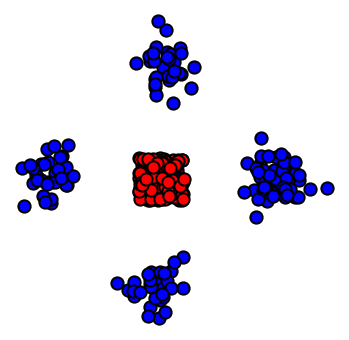

In [24]:
plotp = lambda x,col: plt.scatter(x[0,:], x[1,:], s=150, edgecolors="k", c=col, linewidths=2)
plt.figure(figsize=(6,6))
plotp(x, 'b')
plotp(y, 'r')
plt.axis("off");

Cost matrix $C_{i,j} = \norm{x_i-y_j}^2$.

In [25]:
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
C = distmat(x,y)

Sinkhorn algorithm is originally implemented using matrix-vector
multipliciation, which is unstable for small epsilon.
Here we consider a log-domain implementation, which operates by
iteratively updating so-called Kantorovitch dual potentials $ (f,g) \in \RR^n \times \RR^m $.


The update are obtained by regularized c-transform, which reads
$$ f_i \leftarrow {\min}_\epsilon^b( C_{i,\cdot} - g ) $$
$$ g_j \leftarrow {\min}_\epsilon^a( C_{\cdot,j} - f ),  $$
where the regularized minimum operator reads
$$ {\min}_\epsilon^a(h) \eqdef -\epsilon \log \sum_i a_i e^{-h_i/\epsilon}. $$

In [35]:
def mina_u(H,epsilon, a): return -epsilon*np.log( np.sum(a * np.exp(-H/epsilon),0) )
def minb_u(H,epsilon, b): return -epsilon*np.log( np.sum(b * np.exp(-H/epsilon),1) )

The regularized min operator defined this way is non-stable, but it can
be stabilized using the celebrated log-sum-exp trick, wich relies on the
fact that for any constant $c \in \RR$, one has
$$ {\min}_\epsilon^a(h+c) = {\min}_\epsilon^a(h) + c,  $$
and stabilization is achieved using $c=\min(h)$.

In [36]:
def mina(H,epsilon, a): return mina_u(H-np.min(H,0),epsilon, a) + np.min(H,0);
def minb(H,epsilon, b): return minb_u(H-np.min(H,1)[:,None],epsilon, b) + np.min(H,1);

Value of $\epsilon$. 

In [37]:
epsilon = .01

__Exercise 1__

Implement Sinkhorn in log domain.

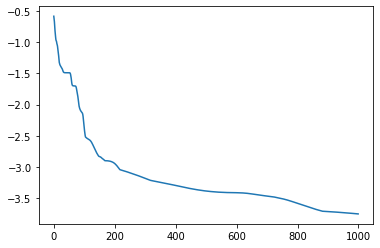

In [44]:
def Sinkhorn(C,epsilon,f, a,b, niter=1000):    
    Err = np.zeros(niter)
    for it in range(niter):
        g = mina(C-f[:,None],epsilon, a)
        f = minb(C-g[None,:],epsilon, b)
        # generate the coupling
        P = a * np.exp((f[:,None]+g[None,:]-C)/epsilon) * b
        # check conservation of mass
        Err[it] = np.linalg.norm(np.sum(P,0)-b,1)
    return (P,Err)
#run with 0 initialization for the potential f
(P,Err) =  Sinkhorn(C,epsilon,np.zeros(n),a,b)  
plt.plot(np.log10(Err));

__Exercise 2__

Study the impact of $\epsilon$ on the convergence rate of the algorithm.

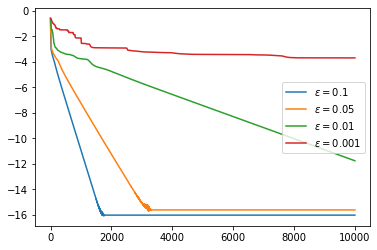

In [46]:
for epsilon in (.1, .05, .01, .001):
    (P,Err) =  Sinkhorn(C,epsilon,np.zeros(n),a,b,10_000)  
    plt.plot(np.log10(Err), label='$\epsilon=$' + str(epsilon))
plt.legend();

As we saw in the previous NT, computing everything in the log-domain allow us to use really small values for epsilon, values which wouldn't work for "regular Sinkhorn". It's interesting that after studying the dual of entropic regularization, the computation in the log-domain comes up "naturally" due to the formulation of the problem and the Primal Dual relation.

In the experiments we are also able to verify that using too small values for epsilon makes the algorithm extremely slower.

Wasserstein Flow for Matching 
------------------------------
We aim at performing a "Lagrangian" gradient (also called Wasserstein flow) descent of Wasserstein
distance, in order to perform a non-parametric fitting. This corresponds
to minimizing the energy function
$$ \Ee(z) \eqdef W_\epsilon\pa{ \frac{1}{n}\sum_i \de_{z_i}, \frac{1}{m}\sum_i \de_{y_i} }. $$


Here we have denoted the Sinkhorn score as
$$ W_\epsilon(\al,\be) \eqdef \dotp{P}{C} - \epsilon \text{KL}(P|ab^\top)$$
where $\al=\frac{1}{n}\sum_i \de_{x_i}$ and
$\be=\frac{1}{m}\sum_i \de_{y_i}$ are the measures (beware that $C$
depends on the points positions).

In [47]:
z = x # initialization

The gradient of this energy reads
$$ ( \nabla \Ee(z) )_i = \sum_j P_{i,j}(z_i-y_j) = a_i z_i - \sum_j P_{i,j} y_j,  $$
where $P$ is the optimal coupling. It is better to consider a renormalized gradient, which corresponds
to using the inner product associated to the measure $a$ on the
deformation field, in which case
$$ ( \bar\nabla \Ee(z) )_i = z_i - \bar y_i   \qwhereq \bar y_i \eqdef \frac{\sum_j P_{i,j} y_j}{a_i}.  $$
Here $\bar y_i$ is often called the "barycentric projection" associated
to the coupling matrix $P$.


First run Sinkhorn, beware you need to recompute the cost matrix at each step.

In [49]:
epsilon = .01
niter = 300
(P,Err) = Sinkhorn(distmat(z,y), epsilon,np.zeros(n),a,b,niter);

Compute the gradient

In [50]:
G = z - ( y.dot(P.transpose()) ) / a.transpose()

Display the gradient field.

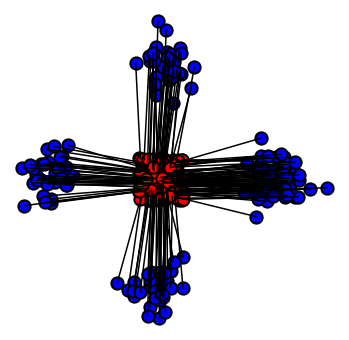

In [51]:
plt.figure(figsize=(6,6))
plotp(x, 'b')
plotp(y, 'r')
for i in range(n):
    plt.plot([x[0,i], x[0,i]-G[0,i]], [x[1,i], x[1,i]-G[1,i]], 'k')
plt.axis("off");

Set the descent step size.

In [52]:
tau = .1

Update the point cloud.

In [53]:
z = z - tau * G

__Exercise 3__

Implement the gradient flow.

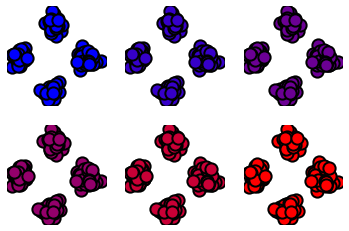

In [54]:
z = x; # initialization
tau = .03; # step size for the descent 
giter = 20; # iter for the gradient descent
ndisp = np.round( np.linspace(0,giter-1,6) )
kdisp = 0
f = np.zeros(n) # use warm restart in the following
for j in range(giter):
    # drawing
    if ndisp[kdisp]==j:        
        plt.subplot(2,3,kdisp+1)
        s = j/(giter-1)
        col = np.array([s,0,1-s])[None,:]
        plotp(z, col )
        plt.axis("off")
        kdisp = kdisp+1
    # Sinkhorn
    (P,Err) = Sinkhorn(distmat(z,y), epsilon,f,a,b,niter)
    # gradient
    G = z - ( y.dot(P.transpose()) ) / a.transpose()
    z = z - tau * G;

For the experiment I've designed the default parameters are not enough for the algorithm to converge. I.e the source point cloud is still far away from the target one after all the iterations.

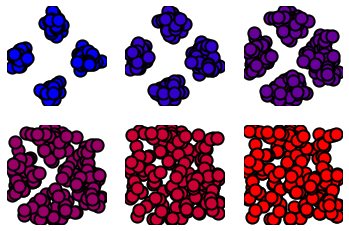

In [55]:
z = x; # initialization
tau = .03; # step size for the descent 
giter = 150; # iter for the gradient descent
ndisp = np.round( np.linspace(0,giter-1,6) )
kdisp = 0
f = np.zeros(n) # use warm restart in the following
for j in range(giter):
    # drawing
    if ndisp[kdisp]==j:        
        plt.subplot(2,3,kdisp+1)
        s = j/(giter-1)
        col = np.array([s,0,1-s])[None,:]
        plotp(z, col )
        plt.axis("off")
        kdisp = kdisp+1
    # Sinkhorn
    (P,Err) = Sinkhorn(distmat(z,y), epsilon,f,a,b,niter)
    # gradient
    G = z - ( y.dot(P.transpose()) ) / a.transpose()
    z = z - tau * G;

With 150 iterations we have convergence.

__Exercise 4__

Show the evolution of the fit as $\epsilon$ increases. What do you observe.
Replace the Sinkhorn score $W_\epsilon(\al,\be)$ by the Sinkhorn divergence
$W_\epsilon(\al,\be)-W_\epsilon(\al,\al)/2-W_\epsilon(\be,\be)/2$.

**Evolution of the fit as epsilon increases**

Text(0.5, 0.98, 'Epsilon: 0.05')

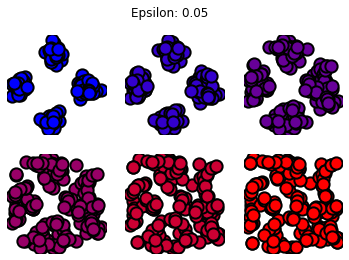

In [56]:
## Insert your code here.
epsilon = .05
z = x; # initialization
tau = .03; # step size for the descent 
giter = 150; # iter for the gradient descent
ndisp = np.round( np.linspace(0,giter-1,6) )
kdisp = 0
f = np.zeros(n) # use warm restart in the following
for j in range(giter):
    # drawing
    if ndisp[kdisp]==j:        
        plt.subplot(2,3,kdisp+1)
        s = j/(giter-1)
        col = np.array([s,0,1-s])[None,:]
        plotp(z, col )
        plt.axis("off")
        kdisp = kdisp+1
    # Sinkhorn
    (P,Err) = Sinkhorn(distmat(z,y), epsilon,f,a,b,niter)
    # gradient
    G = z - ( y.dot(P.transpose()) ) / a.transpose()
    z = z - tau * G;
plt.suptitle(f"Epsilon: {epsilon}")

Text(0.5, 0.98, 'Epsilon: 0.1')

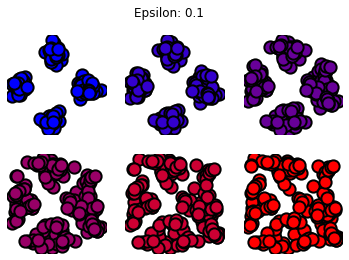

In [57]:
## Insert your code here.
epsilon = .1
z = x; # initialization
tau = .03; # step size for the descent 
giter = 150; # iter for the gradient descent
ndisp = np.round( np.linspace(0,giter-1,6) )
kdisp = 0
f = np.zeros(n) # use warm restart in the following
for j in range(giter):
    # drawing
    if ndisp[kdisp]==j:        
        plt.subplot(2,3,kdisp+1)
        s = j/(giter-1)
        col = np.array([s,0,1-s])[None,:]
        plotp(z, col )
        plt.axis("off")
        kdisp = kdisp+1
    # Sinkhorn
    (P,Err) = Sinkhorn(distmat(z,y), epsilon,f,a,b,niter)
    # gradient
    G = z - ( y.dot(P.transpose()) ) / a.transpose()
    z = z - tau * G;
plt.suptitle(f"Epsilon: {epsilon}")

Text(0.5, 0.98, 'Epsilon: 0.5')

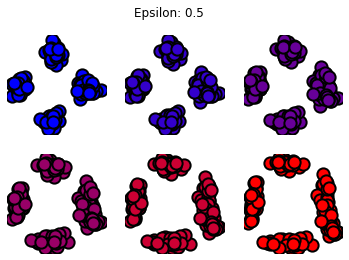

In [58]:
## Insert your code here.
epsilon = .5
z = x; # initialization
tau = .03; # step size for the descent 
giter = 150; # iter for the gradient descent
ndisp = np.round( np.linspace(0,giter-1,6) )
kdisp = 0
f = np.zeros(n) # use warm restart in the following
for j in range(giter):
    # drawing
    if ndisp[kdisp]==j:        
        plt.subplot(2,3,kdisp+1)
        s = j/(giter-1)
        col = np.array([s,0,1-s])[None,:]
        plotp(z, col )
        plt.axis("off")
        kdisp = kdisp+1
    # Sinkhorn
    (P,Err) = Sinkhorn(distmat(z,y), epsilon,f,a,b,niter)
    # gradient
    G = z - ( y.dot(P.transpose()) ) / a.transpose()
    z = z - tau * G;
plt.suptitle(f"Epsilon: {epsilon}")

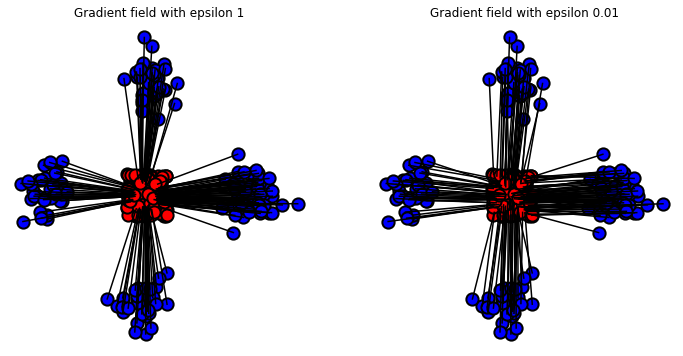

In [59]:
epsilon = 1
z = x

(P,Err) = Sinkhorn(distmat(z,y), epsilon,np.zeros(n),a,b,niter);


G = z - ( y.dot(P.transpose()) ) / a.transpose()

plt.figure(figsize=(12,6))
plt.subplot(121)
plotp(x, 'b')
plotp(y, 'r')
for i in range(n):
    plt.plot([x[0,i], x[0,i]-G[0,i]], [x[1,i], x[1,i]-G[1,i]], 'k')
plt.title(f"Gradient field with epsilon {epsilon}")
plt.axis("off");


epsilon = .01
z = x

(P,Err) = Sinkhorn(distmat(z,y), epsilon,np.zeros(n),a,b,niter);


G = z - ( y.dot(P.transpose()) ) / a.transpose()

plt.subplot(122)
plotp(x, 'b')
plotp(y, 'r')
for i in range(n):
    plt.plot([x[0,i], x[0,i]-G[0,i]], [x[1,i], x[1,i]-G[1,i]], 'k')
plt.title(f"Gradient field with epsilon {epsilon}")
plt.axis("off");

I run the experiments for 3 values of epsilon: 0.05, 0.1, 0.5. As we increase the value of epsilon, the point cloud to which our points converge is more different than the target one. Using larger values for epsilon, causes the computed P to be more different than the optimal P, in fact, the solution gets more dense. Then the gradient field gets less accurate, which causes the algorithm to not converge to the targe point cloud.

Note in the gradient fields comparison how the gradient field for the larger epsilon seem to point to the points on the edge of the cloud, rather to the full cloud. This is exactly what we see in the convergence of the algorithm, which converge to the sides of the square instead of the whole square.

**Sinkhorn divergence**

Text(0.5, 0.98, 'Epsilon 1')

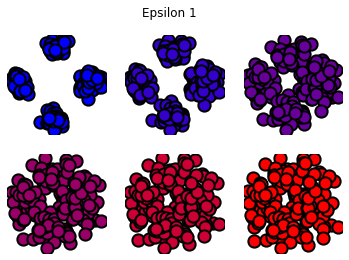

In [88]:
epsilon = 1
z = x; # initialization
tau = .03; # step size for the descent 
giter = 150; # iter for the gradient descent
ndisp = np.round( np.linspace(0,giter-1,6) )
kdisp = 0
f = np.zeros(n) # use warm restart in the following
for j in range(giter):
    # drawing
    if ndisp[kdisp]==j:        
        plt.subplot(2,3,kdisp+1)
        s = j/(giter-1)
        col = np.array([s,0,1-s])[None,:]
        plotp(z, col )
        plt.axis("off")
        kdisp = kdisp+1
    # Sinkhorn
    (P,Err) = Sinkhorn(distmat(z,y), epsilon,f,a,b,niter)
    (Pz, _)= Sinkhorn(distmat(z,z), epsilon,f,a,a,niter)
    # gradient with Sinkhorn divergence
    G = z - ( y.dot(P.transpose())) / a.transpose()
    G -= z - (z@Pz.T) / a.transpose()
    z = z - tau * G;
plt.suptitle(f"Epsilon {epsilon}")

Using the Sinkhorn divergence as an energy for the minimization, allow us to use larger values for epsilon while still converging to the right point cloud. This can be useful, for example, for reducing the number of Sinkhorn iterations, since using a larger epsilon should lead to faster convergence.

Generative Model Fitting
------------------------
The Wasserstein is a non-parametric idealization which does not
corresponds to any practical application. We consider here a simple toy
example of density fitting, where the goal is to find a parameter $\theta$
to fit a deformed point cloud of the form $ (g_\theta(x_i))_i $ using a
Sinkhorn cost. This is ofen called a generative model in the machine
learning litterature, and corresponds to the problem of shape
registration in imaging.


The matching is achieved by solving
$$ \min_\th \Ff(\th) \eqdef \Ee(G_\th(z)) =  W_\epsilon\pa{ \frac{1}{n}\sum_i \de_{g_\th(z_i)}, \frac{1}{m}\sum_i \de_{y_i} },  $$
where the function $G_\th(z)=( g_\th(z_i) )_i$ operates independently on
each point.


The gradient reads
$$ \nabla \Ff(\th) = \sum_i \partial g_\th(z_i)^*[ \nabla \Ee(G_\th(z))_i ], $$
where $\partial g_\th(z_i)^*$ is the adjoint of the Jacobian of
$g_\th$.


We consider here a simple model of affine transformation, where
$\th=(A,h) \in \RR^{d \times d} \times \RR^d $
and $g_\th(z_i)=Az_i+h$.


Denoting $ v_i = \nabla \Ee(G_\th(z))_i $ the gradient of the Sinkhorn
loss (which is computed as in the previous section), the gradient with
respect to the parameter reads
$$ \nabla_A \Ff(\th) = \sum_i  v_i z_i^\top
  \qandq \nabla_h \Ff(\th) = \sum_i  v_i. $$


Generate the data.

In [60]:
epsilon = .01

In [61]:
z = np.random.randn(2,n)*.2
y = np.random.randn(2,m)*.2
y[0,:] = y[0,:]*.05 + 1

Initialize the parameters.

In [62]:
A = np.eye(2)
h = np.zeros(2)

Display the clouds.

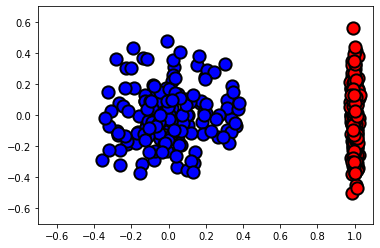

In [63]:
plotp(A.dot(z)+h[:,None], 'b')
plotp(y, 'r')
plt.xlim(-.7,1.1)
plt.ylim(-.7,.7);

Run Sinkhorn.

In [67]:
x = A.dot(z)+h[:,None]
f = np.zeros(n)
(P,Err) = Sinkhorn(distmat(x,y), epsilon,f,a,b,niter)

Compute gradient with respect to positions.

In [68]:
v = a.transpose() * x - y.dot(P.transpose())

gradient with respect to parameters

In [69]:
nabla_A = v.dot(z.transpose())
nabla_h = np.sum(v,1)

__Exercise 5__

Implement the gradient descent.

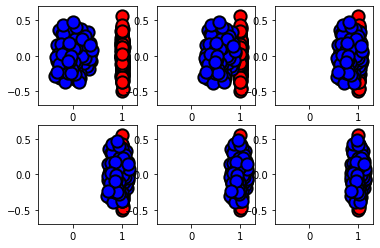

In [70]:
A = np.eye(2)
h = np.zeros(2)
# step size for the descent
tau_A = .8
tau_h = .1
# #iter for the gradient descent
giter = 40 
ndisp = np.round( np.linspace(0,giter-1,6) )
kdisp = 0
f = np.zeros(n)
for j in range(giter):
    x = A.dot(z)+h[:,None] 
    if ndisp[kdisp]==j:
        plt.subplot(2,3,kdisp+1)
        plotp(y, 'r')
        plotp(x, 'b')
        kdisp = kdisp+1
        plt.xlim(-.7,1.3)
        plt.ylim(-.7,.7)
    (P,Err) = Sinkhorn(distmat(x,y), epsilon,f,a,b,niter)
    v = a.transpose() * x - y.dot(P.transpose())
    nabla_A = v.dot(z.transpose())
    nabla_h = np.sum(v,1)
    A = A - tau_A * nabla_A
    h = h - tau_h * nabla_h   

__Exercise 5__

Test using a more complicated deformation (for instance a square being deformed by a random $A$.

With this more complicated example it took much more iterations, but the model converges as well.

In [71]:
z = np.random.rand(2,n)*np.array([.5, .8])[:,None]
y = np.random.rand(2,m)*np.array([2, .5])[:,None] + 2

A = np.eye(2)
h = np.zeros(2)

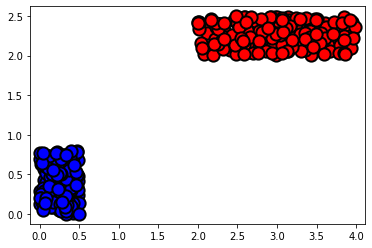

In [72]:
plotp(A.dot(z)+h[:,None], 'b')
plotp(y, 'r')
plt.axis("equal");

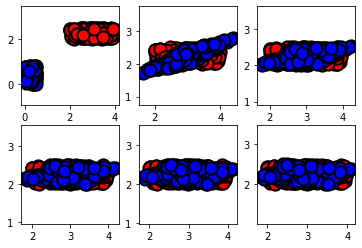

In [73]:
A = np.eye(2)
h = np.zeros(2)
# step size for the descent
tau_A = .8
tau_h = .1
# #iter for the gradient descent
giter = 500
ndisp = np.round( np.linspace(0,giter-1,6) )
kdisp = 0
f = np.zeros(n)
for j in range(giter):
    x = A.dot(z)+h[:,None] 
    if ndisp[kdisp]==j:
        plt.subplot(2,3,kdisp+1)
        plotp(y, 'r')
        plotp(x, 'b')
        kdisp = kdisp+1
        plt.axis('equal')
    (P,Err) = Sinkhorn(distmat(x,y), epsilon,f,a,b,niter)
    v = a.transpose() * x - y.dot(P.transpose())
    nabla_A = v.dot(z.transpose())
    nabla_h = np.sum(v,1)
    A = A - tau_A * nabla_A
    h = h - tau_h * nabla_h   